In [3]:
from PIL import Image
import torch

from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim

In [2]:
transform = transforms.ToTensor()

dataset = datasets.ImageFolder("../data/train", transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

valid_set = datasets.ImageFolder("../data/valid/", transform=transform)

In [4]:
mean = 0.
std = 0.
total = 0.

for images, _ in loader:
    batch_samples = images.size(0)  # batch size
    images = images.view(batch_samples, images.size(1), -1)  # flatten H*W
    
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total += batch_samples

mean /= total
std /= total

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4757, 0.5001, 0.4264])
Std: tensor([0.1847, 0.1592, 0.2024])


In [4]:
mean = torch.tensor([0.4757, 0.5001, 0.4264])
std = torch.tensor([0.1847, 0.1592, 0.2024])

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = datasets.ImageFolder("../data/train", transform=transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

valid_set = datasets.ImageFolder("../data/valid/", transform=transform)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False)

In [6]:
class LeafClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 38)
    def forward(self, x):
      x = torch.relu(self.conv1(x))
      x = torch.max_pool2d(x, 2)
      x = torch.relu(self.conv2(x))
      x = torch.max_pool2d(x, 2)

      x = x.view(x.size(0), -1)

      x = torch.relu(self.fc1(x))
      x = self.fc2(x)
      return x
    
net = LeafClassifier()


net.load_state_dict(torch.load("model_state.pth"))
net.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)


#dummy_data = torch.randn(1, 3, 224, 224)
#output = net(dummy_data)

LeafClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=38, bias=True)
)

In [13]:
num_epochs = 1
net.to(device)
net.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

total = 0
correct = 0

for epoch in range(num_epochs):
    for i, (images, labels) in (enumerate(train_loader, 0)):
        try:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if i % 10 == 0:
                print(i,"out of",len(train_loader))
        except:break
        #if i==150:break

    print()
    torch.save(net.state_dict(), "model_state.pth")
    print(f"Epoch {epoch+1} loss: {loss.item()}, accuracy: {100 * correct / total:.2f}%")


0 out of 2197
10 out of 2197
20 out of 2197
30 out of 2197
40 out of 2197
50 out of 2197
60 out of 2197
70 out of 2197
80 out of 2197
90 out of 2197
100 out of 2197
110 out of 2197
120 out of 2197
130 out of 2197
140 out of 2197
150 out of 2197
160 out of 2197
170 out of 2197
180 out of 2197
190 out of 2197
200 out of 2197
210 out of 2197
220 out of 2197
230 out of 2197
240 out of 2197
250 out of 2197
260 out of 2197
270 out of 2197
280 out of 2197
290 out of 2197
300 out of 2197
310 out of 2197
320 out of 2197
330 out of 2197
340 out of 2197
350 out of 2197
360 out of 2197
370 out of 2197
380 out of 2197
390 out of 2197
400 out of 2197
410 out of 2197
420 out of 2197
430 out of 2197
440 out of 2197
450 out of 2197
460 out of 2197
470 out of 2197
480 out of 2197
490 out of 2197
500 out of 2197
510 out of 2197
520 out of 2197
530 out of 2197
540 out of 2197
550 out of 2197
560 out of 2197
570 out of 2197
580 out of 2197
590 out of 2197
600 out of 2197
610 out of 2197
620 out of 2197
630

In [7]:
import matplotlib.pyplot as plt
print(labels[0].cpu())
plt.imshow(images[0].cpu().permute(1,2,0))

NameError: name 'labels' is not defined

In [29]:
out=net(images[1:2])
torch.argmax(out)

tensor(36, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.968901..2.1946058].


tensor(0, device='cuda:0') tensor(0, device='cuda:0')
Accuracy of the network on the 17572 test images: 87.51%


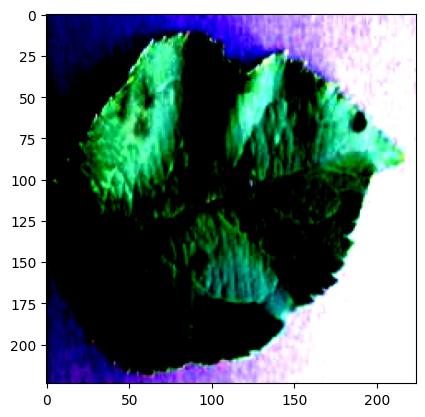

In [16]:


net.eval()
total = 0
correct = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader, 0):
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i == 0:
            print(predicted[0],labels[0])
            plt.imshow(images[0].cpu().permute(1,2,0))

print(f"Accuracy of the network on the {total} test images: {100 * correct / total :.2f}%")


In [19]:
print(f"Accuracy of the network on the {total} test images: {(100 * correct / total):.2f}%")


Accuracy of the network on the 17572 test images: 82.90%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8703692..2.573517].


tensor(37, device='cuda:0') tensor(37, device='cuda:0')


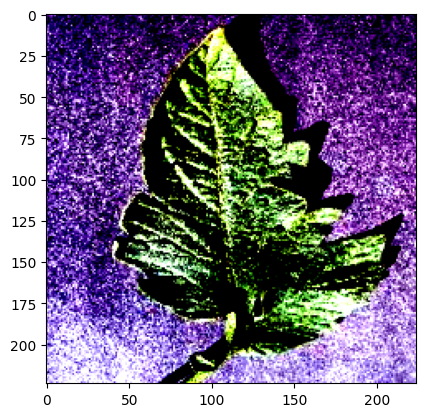

In [23]:
print(predicted[-1],labels[-1])
plt.imshow(images[-1].cpu().permute(1,2,0))

In [8]:
import os
label_mappings={i:x for i,x in enumerate(os.listdir("../data/train"))}

In [34]:
label_mappings[4]

'Blueberry___healthy'

In [20]:
def check_plant_disease(image_path:str, net:LeafClassifier=net):
    try:
        mean = torch.tensor([0.4757, 0.5001, 0.4264])
        std = torch.tensor([0.1847, 0.1592, 0.2024])

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        image=Image.open(image_path)
        image=transform(image)
        image=image.to(device)

        with torch.no_grad():
            output=net(image.unsqueeze(0))
            _,predicted=torch.max(output.data,1)
            return label_mappings[predicted.item()]
    except Exception as e:
        print("Error in process_image:", e)
        return str(e)

    

In [11]:
check_plant_disease(r"..\data\valid\Orange___Haunglongbing_(Citrus_greening)\3295f215-6022-49bc-9bfe-910ee5d0f554___CREC_HLB 4307.JPG")

'Orange___Haunglongbing_(Citrus_greening)'

In [21]:
import gradio as gr

demo = gr.Interface(fn=check_plant_disease, inputs=gr.Image(type="filepath"), outputs="text")
demo.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\queueing.py", line 763, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 2121, in process_api
    inputs = await self.preprocess_data(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 1768, in preprocess_data
    processed_value = block.preprocess(inputs_cached)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\si

Keyboard interruption in main thread... closing server.


In [15]:
import importlib
import typing_extensions

importlib.reload(typing_extensions)

<module 'typing_extensions' from 'c:\\Users\\pc\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\typing_extensions.py'>